In [1]:
import pandas as pd
import numpy as np
from stellargraph import StellarGraph

base_path = "/home/colombelli/Documents/datasets/acgt/kidney/stellargraph/"
edges_file = base_path+"patients_edges.csv"
features_file = base_path+"patients_features.csv"
classes_file = base_path+"patients_classes.csv"

In [2]:
# Imports required for following the tutorial: 
# https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gat-node-classification.html

import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold

In [3]:
# Loading data and building the StellarGraph object

df_patients = pd.read_csv(edges_file)
df_features = pd.read_csv(features_file, index_col=0)
df_classes = pd.read_csv(classes_file, index_col=0).sample(frac=1)

In [4]:
G = StellarGraph(edges=df_patients, nodes=df_features)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 429, Edges: 3618

 Node types:
  default: [429]
    Features: float32 vector, length 500
    Edge types: default-default->default

 Edge types:
    default-default->default: [3618]
        Weights: range=[0.700006, 1], mean=0.817409, std=0.100909
        Features: none


In [15]:
# Splitting data into train/validation/test

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

series_classes = df_classes['class']
#series_classes = series_classes.sample(frac=1)

train_subjects, test_subjects = model_selection.train_test_split(
    series_classes, test_size=1-train_ratio, stratify=series_classes)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, test_size=test_ratio/(test_ratio + validation_ratio), stratify=test_subjects)

print("Len train: ", len(train_subjects))
print("Len validation: ", len(val_subjects))
print("Len test: ", len(test_subjects))
print("\nLen everything: ", len(val_subjects)+len(test_subjects)+len(train_subjects))

Len train:  300
Len validation:  64
Len test:  65

Len everything:  429


In [16]:
from collections import Counter
counter = Counter(train_subjects)
counter

Counter({'stage1': 143,
         'control': 50,
         'stage3': 49,
         'stage2': 24,
         'stage4': 34})

In [17]:
from collections import Counter
counter = Counter(val_subjects)
counter

Counter({'stage4': 8, 'stage1': 30, 'stage3': 10, 'stage2': 5, 'control': 11})

In [18]:
from collections import Counter
counter = Counter(test_subjects)
counter

Counter({'stage3': 11, 'stage2': 5, 'stage4': 7, 'control': 11, 'stage1': 31})

In [19]:
"""
target_encoding.inverse_transform(np.array([[1,0,0,0,0], 
                                            [0,1,0,0,0],
                                            [0,0,1,0,0],
                                            [0,0,0,1,0],
                                            [0,0,0,0,1]]))
"""

'\ntarget_encoding.inverse_transform(np.array([[1,0,0,0,0], \n                                            [0,1,0,0,0],\n                                            [0,0,1,0,0],\n                                            [0,0,0,1,0],\n                                            [0,0,0,0,1]]))\n'

In [10]:
# weights logic taken from: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
num_samples = 0
for cls in counter:
    num_samples += counter[cls]
num_classes = len(counter)

w_control = num_samples / (num_classes * counter['control'])
w_s1 = num_samples / (num_classes * counter['stage1'])
w_s2 = num_samples / (num_classes * counter['stage2'])
w_s3 = num_samples / (num_classes * counter['stage3'])
w_s4 = num_samples / (num_classes * counter['stage4'])

weights = np.array([w_control, w_s1, w_s2, w_s3, w_s4])
weights

array([1.18181818, 0.41935484, 2.6       , 1.18181818, 1.85714286])

## The cell below is used to downsample the training data. Skip it if this is not the goal

In [11]:
"""
train_subjects_downsample = train_subjects.loc[train_subjects == 'stage1'][0:50].append(
            train_subjects.loc[train_subjects == 'stage2'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage3'][0:50]).append(
            train_subjects.loc[train_subjects == 'stage4'][0:50]).append(
            train_subjects.loc[train_subjects == 'control'][0:50])

train_subjects=train_subjects_downsample
Counter(train_subjects_downsample)
"""

"\ntrain_subjects_downsample = train_subjects.loc[train_subjects == 'stage1'][0:50].append(\n            train_subjects.loc[train_subjects == 'stage2'][0:50]).append(\n            train_subjects.loc[train_subjects == 'stage3'][0:50]).append(\n            train_subjects.loc[train_subjects == 'stage4'][0:50]).append(\n            train_subjects.loc[train_subjects == 'control'][0:50])\n\ntrain_subjects=train_subjects_downsample\nCounter(train_subjects_downsample)\n"

In [20]:
# Converting to one-hot encoding

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [71]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout

nb_classes = 5
input_dim = df_features.loc[train_subjects.index].values.shape[1]

model = Sequential()
model.add(Dense(64, input_dim=input_dim))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(64))
model.add(Activation('elu'))
model.add(Dropout(0.15))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), 
              metrics=["acc", metrics.AUC(curve="ROC", name="auc_roc"), metrics.AUC(curve="PR", name="auc_pr")])

X_train = df_features.loc[train_subjects.index].values
y_train = train_targets

X_val = df_features.loc[val_subjects.index].values
y_val = val_targets

print("Training...")
history = model.fit(X_train, y_train, epochs=250, validation_data=(X_val, y_val), batch_size=8, verbose=2)

Training...
Epoch 1/250
38/38 - 1s - loss: 5.2562 - acc: 0.3067 - auc_roc: 0.5808 - auc_pr: 0.2685 - val_loss: 2.5595 - val_acc: 0.4375 - val_auc_roc: 0.6396 - val_auc_pr: 0.3777
Epoch 2/250
38/38 - 0s - loss: 2.5909 - acc: 0.3100 - auc_roc: 0.6344 - auc_pr: 0.3138 - val_loss: 1.6532 - val_acc: 0.5000 - val_auc_roc: 0.7454 - val_auc_pr: 0.5085
Epoch 3/250
38/38 - 0s - loss: 2.1956 - acc: 0.3733 - auc_roc: 0.6823 - auc_pr: 0.3609 - val_loss: 1.3467 - val_acc: 0.5938 - val_auc_roc: 0.8094 - val_auc_pr: 0.5858
Epoch 4/250
38/38 - 0s - loss: 1.5972 - acc: 0.5067 - auc_roc: 0.7807 - auc_pr: 0.5043 - val_loss: 1.2616 - val_acc: 0.6094 - val_auc_roc: 0.8295 - val_auc_pr: 0.6318
Epoch 5/250
38/38 - 0s - loss: 1.4541 - acc: 0.5033 - auc_roc: 0.7946 - auc_pr: 0.5273 - val_loss: 1.2565 - val_acc: 0.5781 - val_auc_roc: 0.8239 - val_auc_pr: 0.6163
Epoch 6/250
38/38 - 0s - loss: 1.4253 - acc: 0.5267 - auc_roc: 0.8065 - auc_pr: 0.5466 - val_loss: 1.2445 - val_acc: 0.5625 - val_auc_roc: 0.8228 - val_a

Epoch 50/250
38/38 - 0s - loss: 0.3556 - acc: 0.8933 - auc_roc: 0.9837 - auc_pr: 0.9463 - val_loss: 1.1130 - val_acc: 0.5938 - val_auc_roc: 0.8770 - val_auc_pr: 0.7154
Epoch 51/250
38/38 - 0s - loss: 0.3942 - acc: 0.8467 - auc_roc: 0.9808 - auc_pr: 0.9405 - val_loss: 1.1197 - val_acc: 0.6250 - val_auc_roc: 0.8825 - val_auc_pr: 0.7267
Epoch 52/250
38/38 - 0s - loss: 0.3615 - acc: 0.8800 - auc_roc: 0.9849 - auc_pr: 0.9511 - val_loss: 1.1160 - val_acc: 0.6094 - val_auc_roc: 0.8835 - val_auc_pr: 0.7320
Epoch 53/250
38/38 - 0s - loss: 0.3378 - acc: 0.8900 - auc_roc: 0.9854 - auc_pr: 0.9556 - val_loss: 1.1623 - val_acc: 0.6562 - val_auc_roc: 0.8826 - val_auc_pr: 0.7365
Epoch 54/250
38/38 - 0s - loss: 0.3461 - acc: 0.8900 - auc_roc: 0.9869 - auc_pr: 0.9550 - val_loss: 1.1592 - val_acc: 0.6562 - val_auc_roc: 0.8839 - val_auc_pr: 0.7200
Epoch 55/250
38/38 - 0s - loss: 0.3289 - acc: 0.8767 - auc_roc: 0.9877 - auc_pr: 0.9590 - val_loss: 1.1723 - val_acc: 0.5938 - val_auc_roc: 0.8770 - val_auc_pr:

Epoch 99/250
38/38 - 0s - loss: 0.1209 - acc: 0.9533 - auc_roc: 0.9988 - auc_pr: 0.9954 - val_loss: 1.3174 - val_acc: 0.5938 - val_auc_roc: 0.8781 - val_auc_pr: 0.7043
Epoch 100/250
38/38 - 0s - loss: 0.1025 - acc: 0.9767 - auc_roc: 0.9993 - auc_pr: 0.9975 - val_loss: 1.3720 - val_acc: 0.5938 - val_auc_roc: 0.8733 - val_auc_pr: 0.6897
Epoch 101/250
38/38 - 0s - loss: 0.1158 - acc: 0.9667 - auc_roc: 0.9988 - auc_pr: 0.9953 - val_loss: 1.4149 - val_acc: 0.6094 - val_auc_roc: 0.8775 - val_auc_pr: 0.7132
Epoch 102/250
38/38 - 0s - loss: 0.0727 - acc: 0.9900 - auc_roc: 0.9998 - auc_pr: 0.9991 - val_loss: 1.4707 - val_acc: 0.5781 - val_auc_roc: 0.8720 - val_auc_pr: 0.6983
Epoch 103/250
38/38 - 0s - loss: 0.0884 - acc: 0.9833 - auc_roc: 0.9990 - auc_pr: 0.9965 - val_loss: 1.4786 - val_acc: 0.6094 - val_auc_roc: 0.8668 - val_auc_pr: 0.6710
Epoch 104/250
38/38 - 0s - loss: 0.0812 - acc: 0.9900 - auc_roc: 0.9999 - auc_pr: 0.9995 - val_loss: 1.4944 - val_acc: 0.5781 - val_auc_roc: 0.8697 - val_au

Epoch 148/250
38/38 - 0s - loss: 0.0559 - acc: 0.9833 - auc_roc: 0.9997 - auc_pr: 0.9988 - val_loss: 1.8171 - val_acc: 0.5469 - val_auc_roc: 0.8498 - val_auc_pr: 0.6818
Epoch 149/250
38/38 - 0s - loss: 0.0537 - acc: 0.9933 - auc_roc: 0.9997 - auc_pr: 0.9987 - val_loss: 1.6804 - val_acc: 0.5781 - val_auc_roc: 0.8618 - val_auc_pr: 0.6881
Epoch 150/250
38/38 - 0s - loss: 0.0440 - acc: 0.9900 - auc_roc: 0.9998 - auc_pr: 0.9992 - val_loss: 1.6996 - val_acc: 0.5625 - val_auc_roc: 0.8522 - val_auc_pr: 0.6794
Epoch 151/250
38/38 - 0s - loss: 0.0326 - acc: 0.9933 - auc_roc: 1.0000 - auc_pr: 0.9999 - val_loss: 1.7000 - val_acc: 0.5625 - val_auc_roc: 0.8590 - val_auc_pr: 0.6805
Epoch 152/250
38/38 - 0s - loss: 0.0398 - acc: 0.9900 - auc_roc: 0.9998 - auc_pr: 0.9993 - val_loss: 1.6226 - val_acc: 0.5469 - val_auc_roc: 0.8714 - val_auc_pr: 0.6958
Epoch 153/250
38/38 - 0s - loss: 0.0557 - acc: 0.9833 - auc_roc: 0.9997 - auc_pr: 0.9990 - val_loss: 1.5824 - val_acc: 0.5938 - val_auc_roc: 0.8745 - val_a

Epoch 197/250
38/38 - 0s - loss: 0.0185 - acc: 0.9933 - auc_roc: 1.0000 - auc_pr: 1.0000 - val_loss: 2.1745 - val_acc: 0.6094 - val_auc_roc: 0.8352 - val_auc_pr: 0.6482
Epoch 198/250
38/38 - 0s - loss: 0.0234 - acc: 0.9933 - auc_roc: 0.9999 - auc_pr: 0.9998 - val_loss: 2.0731 - val_acc: 0.5625 - val_auc_roc: 0.8429 - val_auc_pr: 0.6523
Epoch 199/250
38/38 - 0s - loss: 0.0145 - acc: 0.9967 - auc_roc: 1.0000 - auc_pr: 1.0000 - val_loss: 2.1159 - val_acc: 0.5625 - val_auc_roc: 0.8327 - val_auc_pr: 0.6433
Epoch 200/250
38/38 - 0s - loss: 0.0177 - acc: 0.9967 - auc_roc: 1.0000 - auc_pr: 0.9999 - val_loss: 2.0879 - val_acc: 0.5781 - val_auc_roc: 0.8459 - val_auc_pr: 0.6548
Epoch 201/250
38/38 - 0s - loss: 0.0137 - acc: 1.0000 - auc_roc: 1.0000 - auc_pr: 1.0000 - val_loss: 2.0609 - val_acc: 0.5625 - val_auc_roc: 0.8373 - val_auc_pr: 0.6600
Epoch 202/250
38/38 - 0s - loss: 0.0096 - acc: 1.0000 - auc_roc: 1.0000 - auc_pr: 1.0000 - val_loss: 2.0610 - val_acc: 0.5938 - val_auc_roc: 0.8396 - val_a

Epoch 246/250
38/38 - 0s - loss: 0.0082 - acc: 0.9967 - auc_roc: 1.0000 - auc_pr: 1.0000 - val_loss: 2.3099 - val_acc: 0.5312 - val_auc_roc: 0.8262 - val_auc_pr: 0.6424
Epoch 247/250
38/38 - 0s - loss: 0.0124 - acc: 0.9967 - auc_roc: 1.0000 - auc_pr: 1.0000 - val_loss: 2.2740 - val_acc: 0.5469 - val_auc_roc: 0.8241 - val_auc_pr: 0.6086
Epoch 248/250
38/38 - 0s - loss: 0.0050 - acc: 1.0000 - auc_roc: 1.0000 - auc_pr: 1.0000 - val_loss: 2.2753 - val_acc: 0.5469 - val_auc_roc: 0.8300 - val_auc_pr: 0.6283
Epoch 249/250
38/38 - 0s - loss: 0.0049 - acc: 1.0000 - auc_roc: 1.0000 - auc_pr: 1.0000 - val_loss: 2.2900 - val_acc: 0.5469 - val_auc_roc: 0.8263 - val_auc_pr: 0.6214
Epoch 250/250
38/38 - 0s - loss: 0.0058 - acc: 1.0000 - auc_roc: 1.0000 - auc_pr: 1.0000 - val_loss: 2.2998 - val_acc: 0.5469 - val_auc_roc: 0.8415 - val_auc_pr: 0.6414


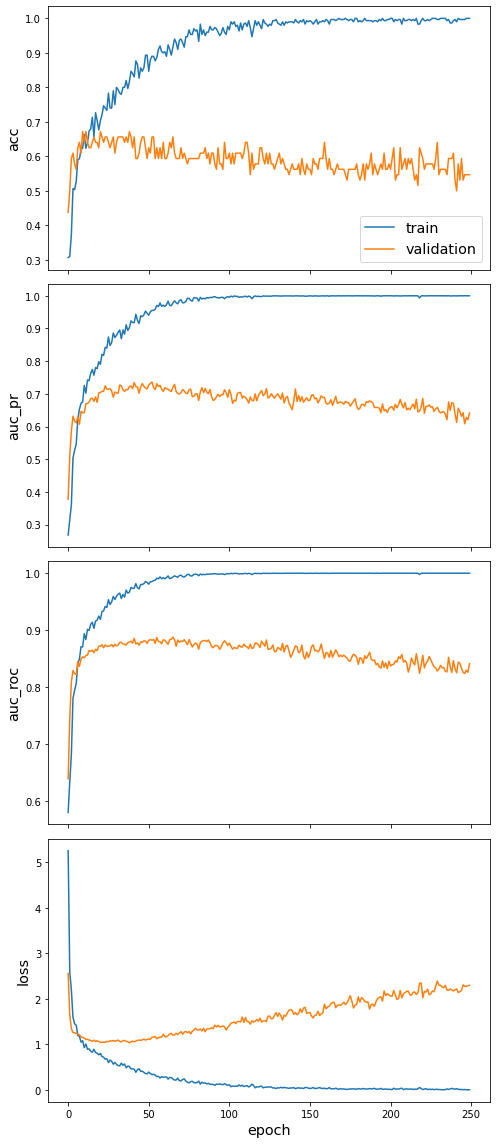

In [72]:
sg.utils.plot_history(history)

In [16]:
X_test = df_features.loc[test_subjects.index].values
y_test = test_targets

test_metrics = model.evaluate(X_test, y_test)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

3/3 [==============================] - 1s 3ms/step - loss: 2.3840 - acc: 0.6308 - auc: 0.8288 - auc_1: 0.6303

Test Set Metrics:
	loss: 2.3840
	acc: 0.6308
	auc: 0.8288
	auc_1: 0.6303


In [17]:
"""
A weighted version of categorical_crossentropy for keras (2.0.6). This lets you apply a weight to unbalanced classes.
@url: https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
@author: wassname
"""
from __future__ import print_function
from tensorflow import cast, int64, float32
from keras import backend as K


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy

    Variables:
        weights: numpy array of shape (C,) where C is the number of classes

    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """

    weights = K.variable(weights)

    def loss(y_true, y_pred):
        y_true = cast(y_true, dtype=float32)
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss

    return loss

In [74]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [75]:
gat = GAT(
    layer_sizes=[64, 64, train_targets.shape[1]],
    activations=["elu", "elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.15,
    attn_dropout=0.15,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()

In [76]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.0001),
    loss='categorical_crossentropy',
    #loss=losses.categorical_crossentropy,
    #loss=weighted_categorical_crossentropy(np.array([1,1,1,1,1])),#weights/(max(weights)+1)),#weights),#weights/(max(weights)+1)),
    metrics=["acc", metrics.AUC(curve="ROC", name="auc_roc"), metrics.AUC(curve="PR", name="auc_pr")])

val_gen = generator.flow(val_subjects.index, val_targets)

In [77]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
    
es_callback = EarlyStopping(
    monitor="val_acc", patience=500#200
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [78]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    #callbacks=[es_callback, mc_callback],
)

Epoch 1/100
1/1 - 5s - loss: 10.3475 - acc: 0.1000 - auc_roc: 0.4195 - auc_pr: 0.1617 - val_loss: 10.8794 - val_acc: 0.0781 - val_auc_roc: 0.4031 - val_auc_pr: 0.1556
Epoch 2/100
1/1 - 0s - loss: 7.9841 - acc: 0.1167 - auc_roc: 0.4349 - auc_pr: 0.1698 - val_loss: 6.9149 - val_acc: 0.0469 - val_auc_roc: 0.3482 - val_auc_pr: 0.1436
Epoch 3/100
1/1 - 0s - loss: 7.4383 - acc: 0.1533 - auc_roc: 0.4839 - auc_pr: 0.1835 - val_loss: 4.6967 - val_acc: 0.0938 - val_auc_roc: 0.3790 - val_auc_pr: 0.1530
Epoch 4/100
1/1 - 0s - loss: 6.9312 - acc: 0.1867 - auc_roc: 0.4900 - auc_pr: 0.1935 - val_loss: 3.3245 - val_acc: 0.1562 - val_auc_roc: 0.4741 - val_auc_pr: 0.1998
Epoch 5/100
1/1 - 0s - loss: 5.8812 - acc: 0.2200 - auc_roc: 0.5495 - auc_pr: 0.2203 - val_loss: 2.7547 - val_acc: 0.3438 - val_auc_roc: 0.6345 - val_auc_pr: 0.3092
Epoch 6/100
1/1 - 0s - loss: 4.4013 - acc: 0.4733 - auc_roc: 0.6860 - auc_pr: 0.3721 - val_loss: 2.9682 - val_acc: 0.4062 - val_auc_roc: 0.6993 - val_auc_pr: 0.3737
Epoch 7/

Epoch 51/100
1/1 - 0s - loss: 3.1549 - acc: 0.5633 - auc_roc: 0.7926 - auc_pr: 0.5311 - val_loss: 2.1537 - val_acc: 0.6719 - val_auc_roc: 0.8151 - val_auc_pr: 0.6175
Epoch 52/100
1/1 - 0s - loss: 3.9417 - acc: 0.4500 - auc_roc: 0.7206 - auc_pr: 0.4294 - val_loss: 2.2057 - val_acc: 0.6719 - val_auc_roc: 0.8042 - val_auc_pr: 0.6216
Epoch 53/100
1/1 - 0s - loss: 3.8156 - acc: 0.5967 - auc_roc: 0.7849 - auc_pr: 0.5393 - val_loss: 2.2221 - val_acc: 0.6719 - val_auc_roc: 0.8076 - val_auc_pr: 0.6289
Epoch 54/100
1/1 - 0s - loss: 3.7410 - acc: 0.5767 - auc_roc: 0.7802 - auc_pr: 0.5459 - val_loss: 2.1941 - val_acc: 0.6719 - val_auc_roc: 0.8073 - val_auc_pr: 0.6259
Epoch 55/100
1/1 - 0s - loss: 3.8288 - acc: 0.5267 - auc_roc: 0.7571 - auc_pr: 0.5016 - val_loss: 2.1592 - val_acc: 0.6719 - val_auc_roc: 0.8132 - val_auc_pr: 0.6280
Epoch 56/100
1/1 - 0s - loss: 4.2095 - acc: 0.5267 - auc_roc: 0.7469 - auc_pr: 0.4892 - val_loss: 2.0780 - val_acc: 0.6719 - val_auc_roc: 0.8089 - val_auc_pr: 0.6203
Epoc

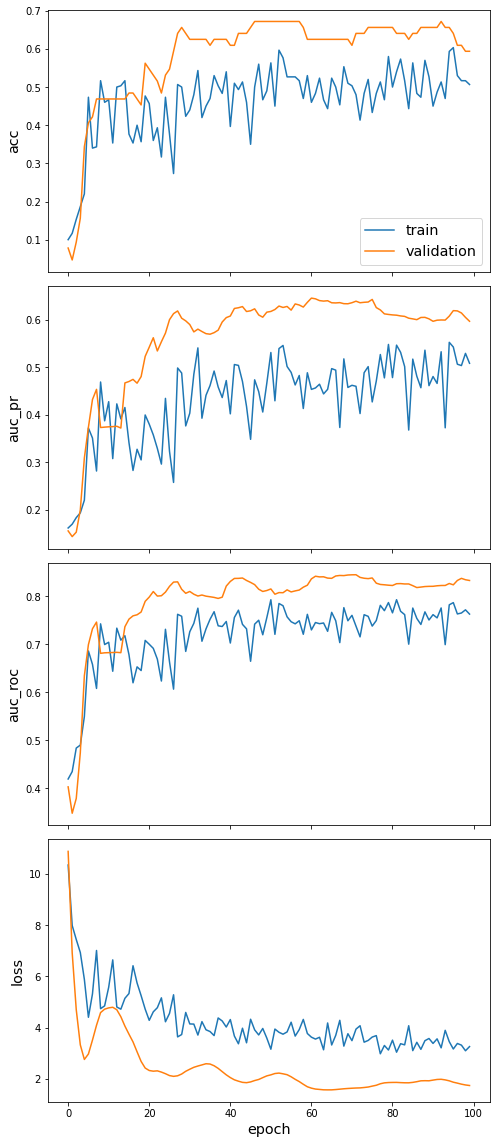

In [80]:
sg.utils.plot_history(history)

In [49]:
model.load_weights("logs/best_model.h5")
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 50ms/step - loss: 1.1347 - acc: 0.6923 - auc_6: 0.8719 - auc_7: 0.6951

Test Set Metrics:
	loss: 1.1347
	acc: 0.6923
	auc_6: 0.8719
	auc_7: 0.6951


In [24]:
all_nodes = series_classes.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [25]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": series_classes})

print(df['True'].value_counts(), "\n")
df['Predicted'].value_counts()

stage1     204
control     72
stage3      70
stage4      49
stage2      34
Name: True, dtype: int64 



stage1     289
control     74
stage4      46
stage3      20
Name: Predicted, dtype: int64

In [26]:
for component in G.connected_components():
    print(len(component))

401
7
3
3
3
2
2
2
2
2
2


In [27]:
G.node_degrees()

defaultdict(int,
            {'TCGA.CJ.5672.11': 70,
             'TCGA.CJ.5678.11': 55,
             'TCGA.B0.5712.11': 45,
             'TCGA.CZ.5458.11': 32,
             'TCGA.CW.5580.11': 70,
             'TCGA.CZ.5463.11': 70,
             'TCGA.CZ.5469.11': 30,
             'TCGA.CZ.4864.11': 49,
             'TCGA.B8.5549.11': 32,
             'TCGA.B0.5701.11': 69,
             'TCGA.CW.5581.11': 51,
             'TCGA.CZ.5455.11': 32,
             'TCGA.B0.5709.11': 54,
             'TCGA.CZ.5470.11': 38,
             'TCGA.CJ.5676.11': 53,
             'TCGA.CZ.5468.11': 39,
             'TCGA.CZ.5982.11': 50,
             'TCGA.CZ.5461.11': 68,
             'TCGA.CZ.5989.11': 35,
             'TCGA.CJ.6030.11': 53,
             'TCGA.CZ.5456.11': 29,
             'TCGA.CJ.5680.11': 52,
             'TCGA.B8.4622.11': 49,
             'TCGA.CW.6087.11': 65,
             'TCGA.B0.5694.11': 56,
             'TCGA.CZ.5466.11': 53,
             'TCGA.CJ.5679.11': 58,
           

## Correlation distribution among patients

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

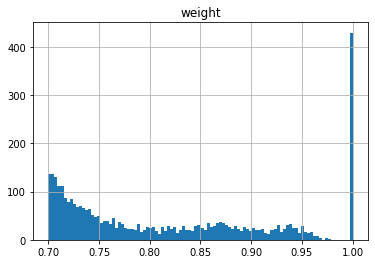

In [28]:
df_patients.hist(column='weight', bins=100)